In [18]:
import os
import argparse
import multiprocessing as mp
from sys import argv

import torch
from torch import nn
import numpy as np

import pytorch_lightning as pl
from tqdm import tqdm
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5EncoderModel
from transformers import AdamW


from Datasets import WikiTable, SquadDataset, Modes
from metrics import compute_exact, compute_f1

# Introdução

Para o trabalho final, optei por trabalhar em um dataset ligeiramente diferente dos utilizados pelos colegas, mas sugeridos pelos professores em sala de aula, chamamado de WikiTableQuestions. A base de dados apresenta uma tarefa comum de Visual Question Answering (VQA), mas em dados tabulares. Para cada tabela, são disponibilizados 4 arquivos:   cada pergunta vem com uma tabela da Wikipedia. Dada a pergunta e a tabela, a tarefa é responder à pergunta com base na tabela. O conjunto de dados contém 2108 tabelas de uma grande variedade de tópicos (mais abrangência) e 22033 perguntas com complexidade diferente (mais profundidade). As tabelas do conjunto de teste não aparecem no conjunto de treinamento, portanto um sistema deve ser capaz de generalizar para tabelas não vistas.

# Metodologia

Optei por utilizar uma metodologia para combinar as informações visuais e textuais através do T5. Sendo assim, como se trata de uma tarefa de VQA, a estratégia adotada foi a de utilizar o encoder do T5 para gerar os embeddings da pergunta e concatenar com os embeddings obtidos da imagem através de uma CNN. Foram testadas duas formas de combinação: 

- Apenas concatenar os embeddings textuais do T5 com as features extraídas da CNN
- O mesmo que o ponto anterior, mas projetando estas features para diminuir a dimensionalidade do problema

Por fim, para gerar a resposta, os novos embeddings servirão como entrada para o decoder do T5 com o intuito de gerar a resposta de acordo com a pergunta e o conteúdo visual.

In [19]:
class ConvBlock(nn.Module):
    """
        Convolutional block from Diedre's code:
        https://github.com/dscarmo/IA376J_final_project/blob/439d3a5639ebc81fe5b6264074a8c4bab25904ba/cnnt5.py#L16
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.LeakyReLU(),
                                   nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.LeakyReLU())

    def forward(self, x):
        return self.block(x)

# CNNTransformer

Classe CNNTransformer que armazenará toda a lógica do problema. Nesta versão apenas avaliei o método de concatenação + MLP, pois foi o método mais incerto e eu não sabia se isso funcionaria ou não.

In [20]:
class CNNTransformer(pl.LightningModule):
    """
        Class for combinining Vision and Language embeddings for generating answers in VQA Task
    """
    def __init__(self, hparams):
        super().__init__()
        
        #Parameters stored in dictionary
        self.hparams = hparams
        
        #Tokenizer for decoding sentences
        self.tokenizer = T5Tokenizer.from_pretrained(self.hparams.t5_model)
        
        #Decoder -> Decode image embedding combined with the last hidden state of the encoder
        self.decoder = T5ForConditionalGeneration.from_pretrained(self.hparams.t5_model)
        
        #Sentence encoder -> just transformer encoder for questions
        if self.hparams.same_enc:
            self.sentence_encoder = self.decoder.get_encoder()
        else:
            self.sentence_encoder = T5EncoderModel.from_pretrained(self.hparams.t5_model)
        
        # Feature adapter for combining image features and transformer 
        # last hidden state from transformer encoder (question)
        # hidden_dim needs to be manually setted
        if not self.hparams.concat_only:
            self.adapter = nn.Linear(self.hparams.hidden_dim, self.hparams.seq_len)
        
        #to align the channel number with transformer's decoder
        self.CNNEmbedder = nn.Sequential(ConvBlock(3, 16),
                                     ConvBlock(16, 64),
                                     ConvBlock(64, 256),
                                     ConvBlock(256, self.decoder.config.d_model))
        
        self.img_shape = (hparams.img_h, hparams.img_w)
        self.sync_dist = self.hparams.gpus > 1
    
    def forward(self, batch):
        table_imgs = batch['table_img']
        questions_ids = batch['question_ids']
        questions = batch['question']
        questions_attn_mask = batch['question_attn_mask']
        answers = batch['answer']
        target_ids = batch['target_ids']
        
        
        #obtain the sentence encoder outputs
        encoder_outputs = self.sentence_encoder(input_ids=questions_ids,
                                                attention_mask=questions_attn_mask,
                                                output_attentions=self.hparams.use_enc_attn)
        
        #batch size x seqlen x self.d_model
        encoder_hidden_state = encoder_outputs.last_hidden_state
        
        #perhaps use attention coming from the sentence encoder
        encoder_attn = encoder_outputs.attentions if self.hparams.use_enc_attn else None 
    
        if self.hparams.debug:
            print(f"batch img shape: {table_imgs.shape}")
        
        #get image embeddings from CNN
        #img_features.shape (B, d_model, H, W)
        img_features = self.CNNEmbedder(table_imgs)
        
        if self.hparams.debug:
            print(f"after cnn.shape: {img_features.shape}")
        
        #(B, C, H, W)
        B = img_features.size(0)
        
        #torch.Size([B, H, W, C]) -> torch.Size([B, H*W, C])
        img_features = img_features.permute(0, 2, 3, 1).view(B, -1, self.decoder.config.d_model)
        img_features = img_features.contiguous()
        
        #torch.Size([B, H*W + seqlen, d_model])
        combined_feat = torch.cat([img_features, encoder_hidden_state], dim=1)
        
        proj_features = None
        if self.hparams.concat_only:
            proj_features = combined_feat
        else:
            #torch.Size([B, d_model, H*W + seqlen])
            combined_feat = combined_feat.permute(0, 2, 1)

            if self.hparams.debug:
                print(f"Combined feat.shape: {combined_feat.shape}")

            #torch.Size([B, d_model, hidden_dim=hidden_state_dim])
            proj_features = self.adapter(combined_feat)

            #torch.Size([B, hidden_state_dim, d_model]) -- ready to be used as last hidden state!    
            proj_features = proj_features.permute(0, 2, 1)
        
        assert proj_features is not None, "Projected features are None"
        
        if self.hparams.debug:
            print(f"proj feat.shape: {proj_features.shape}")
        
        if self.training:
            loss = self.decoder(encoder_outputs=(proj_features, encoder_attn),
                                labels=target_ids).loss
            
            return loss
        else:
            
            return self.generate_predictions(hiddn_states=proj_features,
                                             encoder_attentions=encoder_attn)
        
    def training_step(self, batch, batch_idx):
        loss = self(batch)
        
        self.log('loss', torch.Tensor([loss]).to(self.device), on_epoch=True, 
                 on_step=True, prog_bar=True, sync_dist=self.sync_dist)
        return loss
    
    
    def generate_predictions(self, hiddn_states, encoder_attentions=None):
        '''
        Adaptação de código da aula 10 do semestre passado.
        Usa features construídas externamente para gerar frases com T5.
        '''
        #max len for generated sequence
        max_seq_len = self.hparams.seq_len
        
        #decoded ids. Initial tokens for decoding for each batch
        decoded_ids = torch.full((hiddn_states.size(0), 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(hiddn_states.device)
        
        #combined hidden states (image + text)
        encoder_hidden_states = hiddn_states
        
        #decoding time!
        for step in range(max_seq_len):
            #get the next token id given the ones decoded so far
            outputs = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=(encoder_hidden_states, encoder_attentions),
                                  return_dict=True)
            #take the logits
            logits = outputs["logits"]
            
            #get last logits
            next_token_logits = logits[:, -1, :]

            # Greedy decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)

            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids
    
    
    def evaluation_step(self, batch):
        '''
        Same step for validation and testing.
        '''
        #get the predictions
        pred_tokens = self(batch)
        preds = self.tokenizer.batch_decode(pred_tokens, skip_special_tokens=True) 

        return batch["answer"], preds
    
    def validation_step(self, batch, batch_idx):
        return self.evaluation_step(batch)

    def test_step(self, batch, batch_idx):
        return self.evaluation_step(batch)
    
    def validation_epoch_end(self, outputs):
        return self.epoch_end(outputs, "val")

    def test_epoch_end(self, outputs):
        return self.epoch_end(outputs, "test")
    
    def epoch_end(self, outputs, step):
        tgts, preds = [], []
        for output in outputs:
            tgts += output[0]
            preds += output[1]

        f1s, exacts = [], []
        for tgt, pred in zip(tgts, preds):
            f1s.append(compute_f1(tgt, pred))
            exacts.append(compute_exact(tgt, pred))
        if self.hparams.debug:
            print(f"Preds: {preds}")
            print(f"Real: {tgts}")
        else:
            self.logger.experiment.log_text("Outputs", f"Preds: {preds[-10:]} \n Real: {tgts[-10:]} \n\n")

        
        self.log(f"f1_{step}", torch.Tensor([np.array(f1s).mean()]).to(self.device),
                 prog_bar=True, on_step=False, on_epoch=True, sync_dist=self.sync_dist)
        
        self.log(f"{step}_exact_match", torch.Tensor([np.array(exacts).mean()]).to(self.device),
                 prog_bar=True, on_step=False, on_epoch=True, sync_dist=self.sync_dist)
         
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    
    def train_dataloader(self):
        ds = None
        if self.hparams.pretrain:
            print(f"Pretrainig using {self.hparams.squad} - Train")
            ds = SquadDataset(Modes.TRAIN, self.tokenizer, self.hparams.squad, max_len=self.hparams.seq_len)
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=True, 
                          num_workers=self.hparams.nworkers, collate_fn=self.collate)
        else:
            print(f"Training using Wikitable")
            ds = WikiTable(Modes.TRAIN, self.tokenizer, self.img_shape, max_len=self.hparams.seq_len)
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=True, 
                              num_workers=self.hparams.nworkers)

    def val_dataloader(self):
        ds = None
        if self.hparams.pretrain:
            ds = SquadDataset(Modes.VAL, self.tokenizer, self.hparams.squad, max_len=self.hparams.seq_len)
            print(f"Pretrainig using {self.hparams.squad} - Valid")
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=True, 
                              num_workers=self.hparams.nworkers, collate_fn=self.collate)
        else:
            print(f"Validating with Wikitable ")
            ds = WikiTable(Modes.VAL, self.tokenizer, self.img_shape, max_len=self.hparams.seq_len)
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=False, 
                          num_workers=self.hparams.nworkers)

    def test_dataloader(self):
        ds = None
        if self.hparams.pretrain:
            print(f"Pretrainig using {self.hparams.squad} - Test")
            ds = SquadDataset(Modes.TEST, self.tokenizer, self.hparams.squad, max_len=self.hparams.seq_len)
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=True, 
                              num_workers=self.hparams.nworkers, collate_fn=self.collate)
        else:
            print(f"Testing with Wikitable")
            ds = WikiTable(Modes.TEST, self.tokenizer, self.img_shape, max_len=self.hparams.seq_len)
            return DataLoader(ds, batch_size=self.hparams.batch_size, shuffle=False, 
                          num_workers=self.hparams.nworkers)
    
    def collate(self, batch):
        imgs = [b['table_img'].numpy() for b in batch]
        questions = [b['question'] for b in batch]
        answers = [b['answer'] for b in batch]

        input_tokens = self.tokenizer.batch_encode_plus(questions, return_tensors="pt", padding="longest")
        target_ids = self.tokenizer.batch_encode_plus(answers, return_tensors="pt", padding="longest")

        target_ids["input_ids"][target_ids["input_ids"] == 0] = -100  

        return {
                "table_img": torch.tensor(imgs, dtype=torch.float),
                "question_ids": input_tokens["input_ids"],
                "question_attn_mask": input_tokens["attention_mask"],
                "target_ids": target_ids["input_ids"],
                "question": questions,
                "answer": answers,

        }

In [ ]:
if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--pretrain", action='store_true', help="Pretrain or Train")
#     parser.add_argument("--t5_model", type=str, default="t5-base", help="T5 weights to load.")
#     parser.add_argument("--squad", type=str, default="squad_v2", help="Pretrain using squad or squad_v2")
#     parser.add_argument("--seq_len", type=int, default=128, help="Transformer sequence length.")
#     parser.add_argument("--lr", type=float, default=5e-4, help="ADAM Learning Rate.")
#     parser.add_argument("--batch_size", type=int, default=2, help="Batch size.")
#     parser.add_argument("--gpus", type=int, default=1, help="Number of GPUs.")
#     parser.add_argument("--acum", type=int, default=1, help="Acum for batch.")
#     parser.add_argument("--precision", type=int, default=32, help="Precision.")
#     parser.add_argument("--max_epochs", type=int, default=10, help="Maximum number of epochs.")
#     parser.add_argument("--patience", type=int, default=2, help="How many epochs to wait for improvement in validation.")
#     parser.add_argument("--nworkers", type=int, default=mp.cpu_count(), help="Number of workers to use in dataloading.")
#     parser.add_argument("--experiment_name", type=str, default="baseline", help="Single word describing experiment.")
#     parser.add_argument("--description", type=str, default="No description.", help="Single phrase describing experiment.")
#     parser.add_argument("--hidden_dim", type=int, default=1152, help="Input dim for Linear projections. Needs to be adjusted manually according to image shape")
#     parser.add_argument("--img_w", type=int, default=500, help="Image shape for resizing in dataset creation")
#     parser.add_argument("--img_h", type=int, default=500, help="Image shape for resizing in dataset creation")
#     parser.add_argument("--use-enc-attn", action="store_true", help="Use Encoder Attention during decoding")
#     parser.add_argument("--same-enc", action="store_true", help="Use separe encoder and decoder or not")
#     parser.add_argument("--debug", action="store_true", help="Fast dev run mode.")
#     parser.add_argument("--load", type=str, default=None, help="Pre trained model to start with.")
#     parser.add_argument("--accelerator", type=str, default='ddp', help="Multiple GPUs Accelerator")
#     parser.add_argument("--cpu", action="store_true", help="Force using CPU.")
    
    #uncommend if running through CLI
#     hparams = parser.parse_args()
    
    #uncommend if running through Jupyter
    hparams = parser.parse_args([])
    
    print("Hyperparameters")
    for k, v in vars(hparams).items():
        print(f"{k}: {v}")
    
    if hparams.debug:
        logger = False
        callbacks = None
    else:
        logger = NeptuneLogger(api_key=os.getenv('NEPTUNE_API_TOKEN'),
                               project_name="levy.gurgel/wikitable",
                               experiment_name=hparams.experiment_name,
                               tags=[hparams.description],
                               params=vars(hparams))
        
        dir_path = os.path.join("models", hparams.experiment_name)
        filename = "{epoch}-{val_exact_match:.2f}-{f1_val:.2f}-same"
        callbacks = [ModelCheckpoint(prefix=hparams.experiment_name,
                                     dirpath=dir_path,
                                     filename=filename,
                                     monitor="f1_val",
                                     mode="max")]
    
    model = CNNTransformer(hparams=hparams)

    trainer = pl.Trainer(max_epochs=hparams.max_epochs,
                                 gpus=0 if hparams.cpu else hparams.gpus,
                                 accumulate_grad_batches=hparams.acum,
                                 precision=hparams.precision,
                                 fast_dev_run=hparams.debug,
                                 logger=logger,
                                 callbacks=callbacks,
                                 checkpoint_callback=False if hparams.debug else True,
                                 accelerator=None if hparams.gpus <= 1 else hparams.accelerator
                                 
                        )
    trainer.fit(model)

# Predição em Test

Após o treinamento do modelo no dataset original do WikiTable, iremos fazer o teste no mesmo. É importante notar que neste notebook não inseri qualquer pré-treinamento, mas todo os logs e pré-treinamento pode ser visto no meu github: https://github.com/VirtualSpaceman/ia376

In [21]:
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument("--pretrain", action='store_true', help="Pretrain or Train")
parser.add_argument("--t5_model", type=str, default="t5-base", help="T5 weights to load.")
parser.add_argument("--squad", type=str, default="squad_v2", help="Pretrain using squad or squad_v2")
parser.add_argument("--seq_len", type=int, default=32, help="Transformer sequence length.")
parser.add_argument("--lr", type=float, default=5e-4, help="ADAM Learning Rate.")
parser.add_argument("--batch_size", type=int, default=6, help="Batch size.")
parser.add_argument("--gpus", type=int, default=1, help="Number of GPUs.")
parser.add_argument("--acum", type=int, default=1, help="Acum for batch.")
parser.add_argument("--precision", type=int, default=32, help="Precision.")
parser.add_argument("--max_epochs", type=int, default=10, help="Maximum number of epochs.")
parser.add_argument("--patience", type=int, default=1, help="How many epochs to wait for improvement in validation.")
parser.add_argument("--nworkers", type=object, default=os.cpu_count(), help="Number of workers to use in dataloading.")
parser.add_argument("--experiment_name", type=str, default="baseline", help="Single word describing experiment.")
parser.add_argument("--description", type=str, default="No description.", help="Single phrase describing experiment.")
parser.add_argument("--hidden_dim", type=int, default=3832, help="Input dim for Linear projections. Needs to be adjusted manually according to image shape")
parser.add_argument("--img_w", type=int, default=1600, help="Image shape for resizing in dataset creation")
parser.add_argument("--img_h", type=int, default=600, help="Image shape for resizing in dataset creation")
parser.add_argument("--use-enc-attn", action="store_true", help="Use Encoder Attention during decoding")
parser.add_argument("--debug", action="store_true", help="Fast dev run mode.")
parser.add_argument("--load", type=str, default=None, help="Pre trained model to start with.")
parser.add_argument("--accelerator", type=str, default='ddp', help="Multiple GPUs Accelerator")
parser.add_argument("--cpu", action="store_true", help="Force using CPU.")
parser.add_argument("--same_enc", action="store_false", help="same encoder.")
parser.add_argument("--concat_only", action="store_false", help="same encoder.")

#uncommend if running through CLI
hparams = parser.parse_args([])
print(hparams)

device = 'cuda:1'

# model = CNNTransformer.load_from_checkpoint("/models/squadpretrain/squadpretrain-epoch=0-val_extact_match=0.00-f1_val=0.50.ckpt", strict=False, params=hparams).eval().cuda()
model = CNNTransformer.load_from_checkpoint("/models-ft/wikitable-squadv1-pretrain/wikitable-squadv1-pretrain-epoch=2-val_exact_match=0.05-f1_val=0.08-same.ckpt", strict=False, hparams=hparams).eval().to(device)

Namespace(accelerator='ddp', acum=1, batch_size=6, concat_only=True, cpu=False, debug=False, description='No description.', experiment_name='baseline', gpus=1, hidden_dim=3832, img_h=600, img_w=1600, load=None, lr=0.0005, max_epochs=10, nworkers=72, patience=1, precision=32, pretrain=False, same_enc=True, seq_len=32, squad='squad_v2', t5_model='t5-base', use_enc_attn=False)


Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
model.hparams.batch_size = 15
model.hparams.nworkers = 4
test_dataloader = model.test_dataloader()

Testing with Wikitable


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


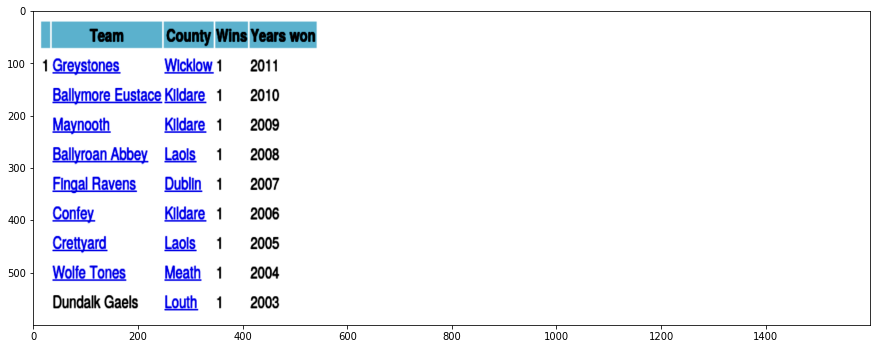

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: which team won previous to crettyard?
prediction: ngelangel
target: Wolfe Tones
F1: 0, Exact: 0



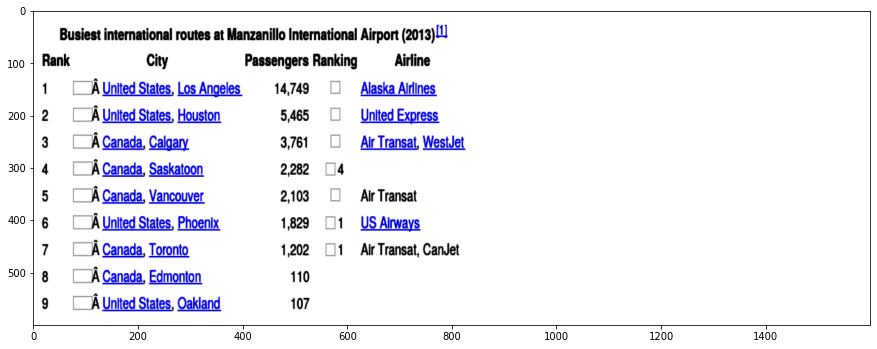

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: how many more passengers flew to los angeles than to saskatoon from manzanillo airport in 2013?
prediction: 59,095
target: 12467
F1: 0, Exact: 0



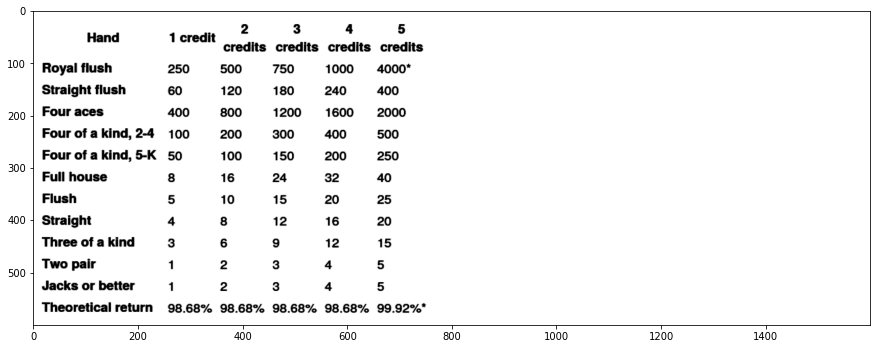

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: after winning on four credits with a full house what is your payout?
prediction: $1.50............
target: 32
F1: 0, Exact: 0



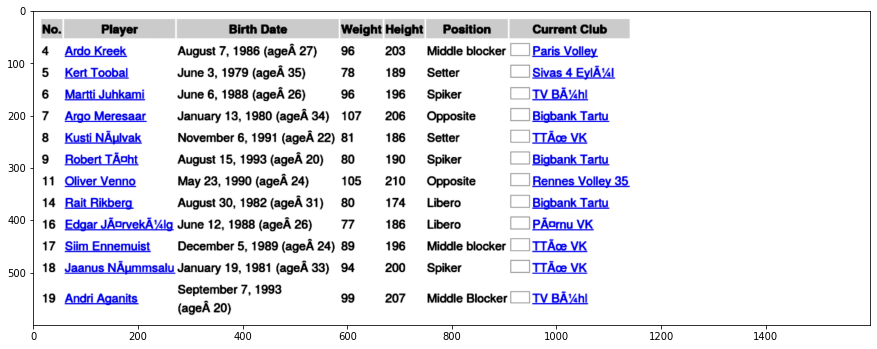

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: which players played the same position as ardo kreek?
prediction: lvaro Kossovilininini
target: Siim Ennemuist|Andri Aganits
F1: 0, Exact: 0



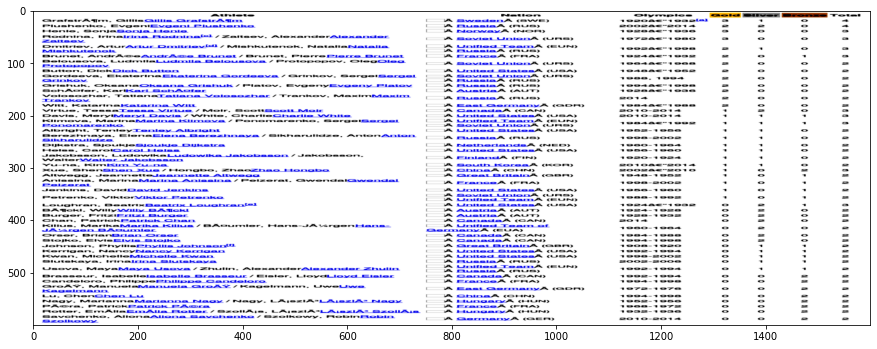

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: which athlete was from south korea after the year 2010?
prediction: Kimi Takahashi
target: Kim Yu-na
F1: 0, Exact: 0



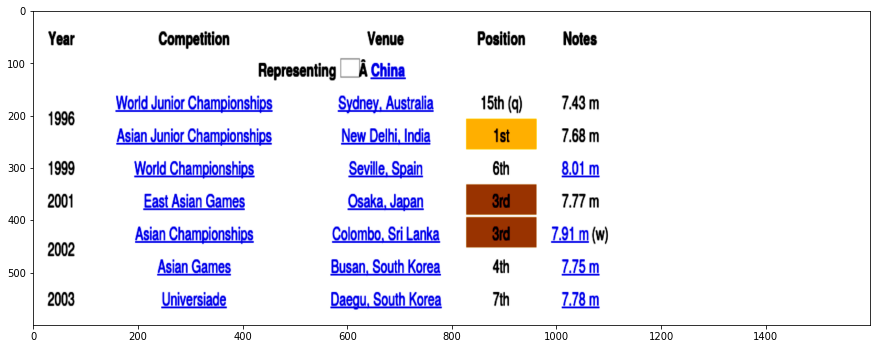

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: what was the venue when he placed first?
prediction: Xiamen, China d'Ira d'Aragon
target: New Delhi India
F1: 0, Exact: 0



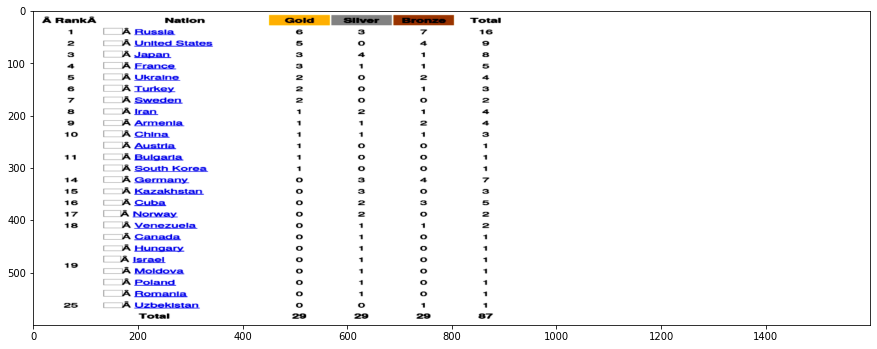

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: who ranked right after turkey?
prediction: Turkey
target: Sweden
F1: 0, Exact: 0



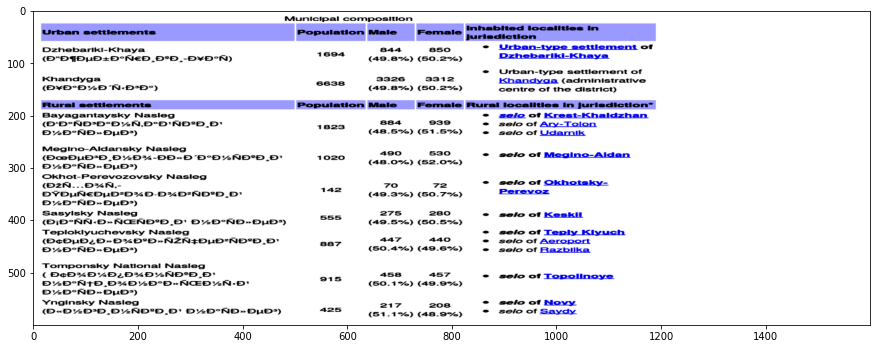

Question: what is the total population in dzhebariki-khaya?
prediction: 69,079
target: 1694
F1: 0, Exact: 0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


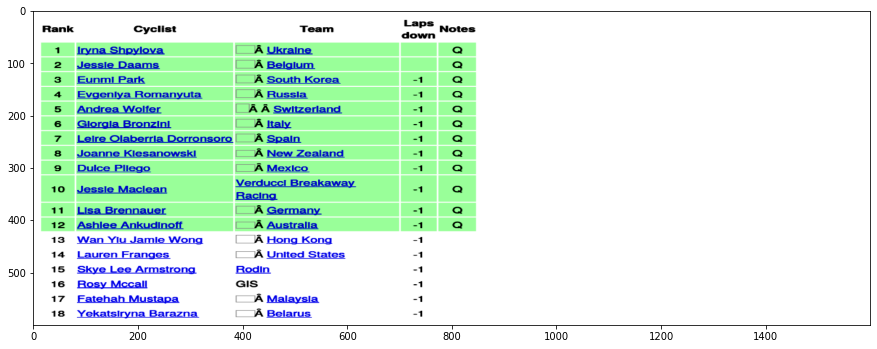

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: who was the top ranked competitor in this race?
prediction: Michael Jackson d'Arc de la Plata d'Ar
target: Iryna Shpylova
F1: 0, Exact: 0



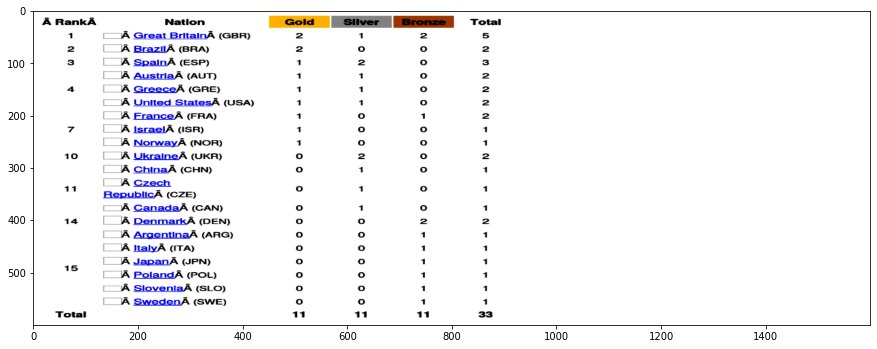

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: what was the number of silver medals won by ukraine?
prediction: 2
target: 2
F1: 1.0, Exact: 1



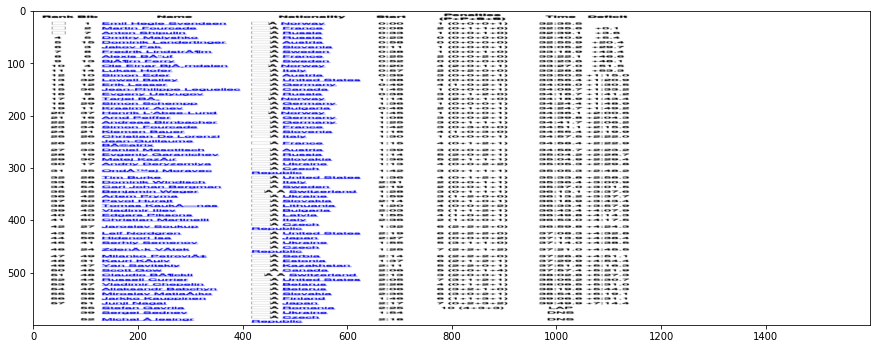

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: what is the largest penalty?
prediction: 0
target: 10
F1: 0, Exact: 0



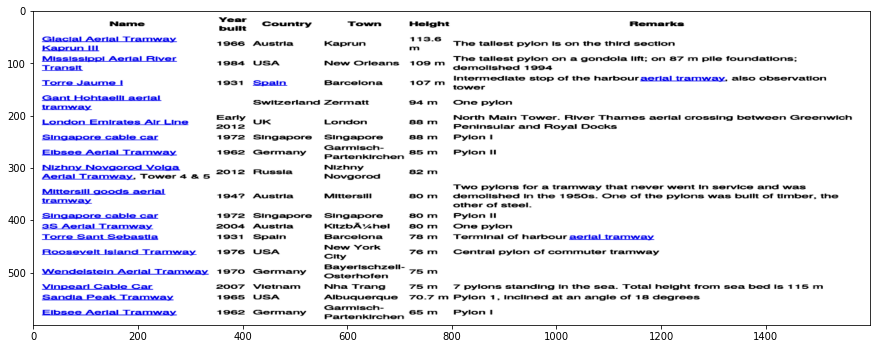

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: what is the total number of pylons listed?
prediction: 3
target: 17
F1: 0, Exact: 0



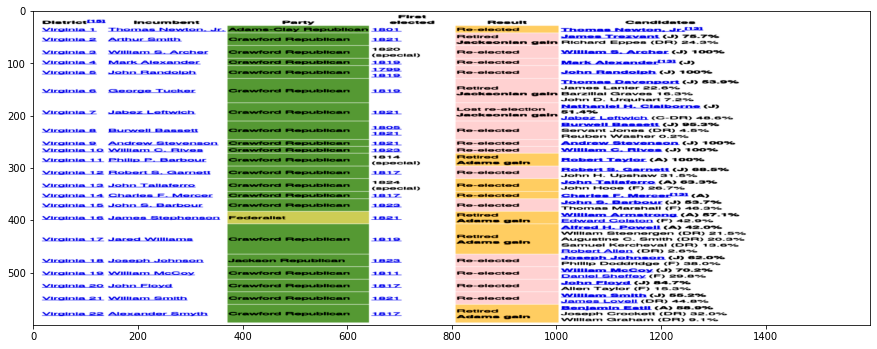

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: how many districts are there in virginia?
prediction: 3
target: 22
F1: 0, Exact: 0



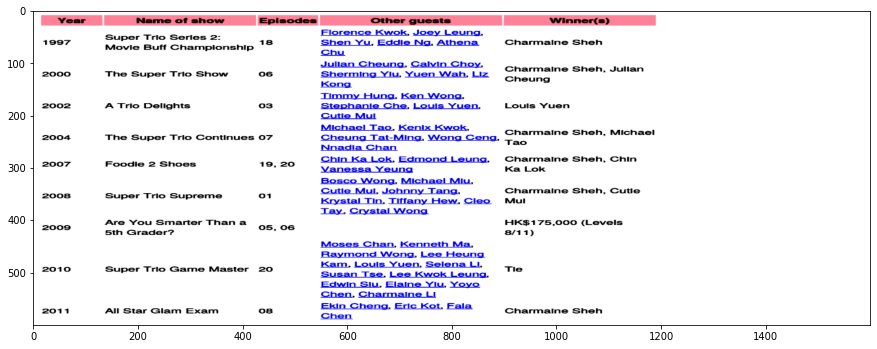

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question: what is the number of tv shows that charmaine sheh has appeared on?
prediction: 2 2 2 2 2 2 2 2 2 2
target: 9
F1: 0, Exact: 0



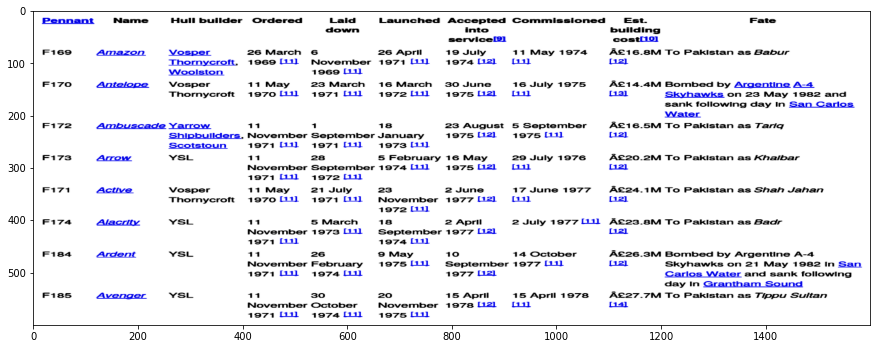

Question: amazon is at the top of the chart but what is the name below it?
prediction: Amazon.com
target: Antelope
F1: 0, Exact: 0



In [23]:
batch = next(iter(test_dataloader))
cuda_batch = {}
for k, v in batch.items():
    if k in ["answer", "question"]:
        cuda_batch[k] = v
    else:
        cuda_batch[k] = v.to(device)  
batch = cuda_batch


tokenizer = model.tokenizer
model.eval()
with torch.no_grad():
    output = model(batch)

output_text = tokenizer.batch_decode(output, skip_special_tokens=True) 


tgt_text = batch["answer"]
for i in range(model.hparams.batch_size):
    plt.figure(figsize=(15, 15))
    img = batch['table_img'][i]
    table = np.transpose(img.cpu().numpy(), (1, 2, 0)) 
    plt.imshow(table)
    plt.show()
    print(f"Question: {batch['question'][i]}")
    print(f"prediction: {output_text[i]}\ntarget: {tgt_text[i]}\nF1: {compute_f1(output_text[i], tgt_text[i])}, Exact: {compute_exact(output_text[i], tgt_text[i])}\n")


In [24]:
#Computando o Exact match e o F1 para os dados de teste

tokenizer = model.tokenizer
model.eval()

em_vals = []
f1_vals = []


for batch in test_dataloader:    
    cuda_batch = {}
    for k, v in batch.items():
        if k in ["answer", "question"]:
            cuda_batch[k] = v
        else:
            cuda_batch[k] = v.to(device)  
    batch = cuda_batch

    with torch.no_grad():
        output = model(batch)

    output_text = tokenizer.batch_decode(output, skip_special_tokens=True) 

    tgt_text = batch["answer"]
    for i in range(batch['table_img'].size(0)):
        em_vals.append(compute_exact(tgt_text[i], output_text[i]))
        f1_vals.append(compute_f1(tgt_text[i], output_text[i]))
        

print(f"EM-Test: {np.mean(em_vals)} \n F1-Test : {np.mean(f1_vals)}")

EM-Test: 0.04945249028611798 
 F1-Test : 0.08494968322264829
